In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("../recordings/pupil_hr_log.csv")
df["pupil_radius"] = df["pupil_radius"].rolling(window=3, min_periods=1).mean()

In [3]:
df

,timestamp,frame_idx,elapsed_sec,pupil_x,pupil_y,pupil_radius,heart_rate
0,2025-06-05T17:08:21.798939,0,0.69,363.33,322.00,31.210000,75.34
1,2025-06-05T17:08:21.899525,1,0.79,364.00,321.33,31.360000,75.39
2,2025-06-05T17:08:21.909080,2,0.80,364.17,321.50,31.396667,75.40
3,2025-06-05T17:08:21.916644,3,0.80,364.17,321.67,31.490000,75.40
4,2025-06-05T17:08:21.924639,4,0.81,364.17,321.67,31.483333,75.41
...,...,...,...,...,...,...,...
875,2025-06-05T17:08:50.971224,875,29.86,347.17,304.50,30.536667,75.78
876,2025-06-05T17:08:50.979821,876,29.87,347.17,304.67,30.560000,75.77
877,2025-06-05T17:08:51.100607,877,29.99,347.83,304.50,30.500000,75.71
878,2025-06-05T17:08:51.110604,878,30.00,347.83,304.67,30.440000,75.71


In [4]:
def create_sequences(data, target, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)


In [5]:
radius = df["pupil_radius"].values
hr = df["heart_rate"].values


In [6]:
scaler = MinMaxScaler()
radius = scaler.fit_transform(radius.reshape(-1, 1)).flatten()

In [7]:
X, y = create_sequences(radius, hr, window_size=30)
X = X[..., np.newaxis]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

c:\Users\manit\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 5909.6880 - mae: 76.8373 - val_loss: 4775.3940 - val_mae: 69.0916
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4428.6367 - mae: 66.4791 - val_loss: 3272.3713 - val_mae: 57.1894
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2866.6646 - mae: 53.3610 - val_loss: 1674.9467 - val_mae: 40.9048
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1376.1169 - mae: 36.6793 - val_loss: 559.9136 - val_mae: 23.6255
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 447.3255 - mae: 20.1127 - val_loss: 102.0579 - val_mae: 10.0155
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 102.0479 - mae: 8.3862 - val_loss: 10.9766 - val_mae: 3.0380
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 48.2482 - mae: 5.5361 - val_loss: 2.2340 - val_mae: 1.3245
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 52.4936 - mae: 5.8482 - val_loss: 1.7723 - val_mae: 1.1505
Epoch 9/30
43/43 ━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


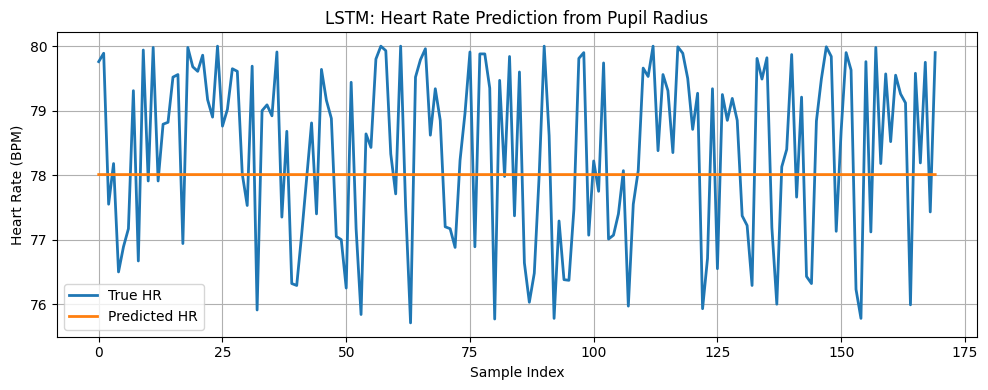

In [15]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(10, 4))
plt.plot(y_test, label="True HR", linewidth=2)
plt.plot(y_pred, label="Predicted HR", linewidth=2)
plt.title("LSTM: Heart Rate Prediction from Pupil Radius")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (BPM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()